In [21]:
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.autograd import Variable
from PIL import Image

import robosims
import json
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [22]:
class RecogNet(object):
    def __init__(self, model_name='VGG'):
        # import pretrained model and remove the soft-max layer
        if model_name == 'ResNet':
            self.model = models.resnet50(pretrained=True)
            new_classifier = nn.Sequential(*list(self.model.children())[:-1])
            self.model = new_classifier
        else:
            self.model = models.vgg19(pretrained=True)
            new_classifier = nn.Sequential(*list(self.model.classifier.children())[:-1])
            self.model.classifier = new_classifier

    def feat_extract(self, frame):
        # normalize the input image
        normalize = transforms.Normalize(
           mean=[0.485, 0.456, 0.406],
           std=[0.229, 0.224, 0.225]
        )
        preprocess = transforms.Compose([
           transforms.Scale(224),
           # transforms.CenterCrop(224),
           transforms.ToTensor(),
           normalize
        ])
        image = Image.fromarray(frame)
        img_tensor = preprocess(image)
        # extract features
        img_tensor.unsqueeze_(0)
        return self.model(Variable(img_tensor))

In [57]:
"""  Test feature extraction by 2D embedding """
architecture = 'ResNet'
# num_samples = 36 # for rotation degree form 0, 10, ..., 350
num_samples = 360 # for rotation degree form 0, 1, ..., 359
degree = float(360 // num_samples)

if architecture == 'ResNet':
    num_features = 2048
else:
    num_features = 4096

# initialize environment
env = robosims.controller.ChallengeController(
    unity_path='../thor-201705011400-OSXIntel64.app/Contents/MacOS/thor-201705011400-OSXIntel64',
    x_display="0.0", # this parameter is ignored on OSX, but you must set this to the appropriate display on Linux
    mode='continuous'
)
env.start()
with open("../thor-challenge-targets/targets-train.json") as f:
    t = json.loads(f.read())
target = t[1900]
env.initialize_target(target)
event = env.step(action=dict(action='Look', horizon=0.0))

# initialize network
recog_net = RecogNet(architecture)
image_feature = np.zeros((num_samples, num_features))
    
# extract features
for i in range(num_samples):
#     print(i)
    event = env.step(action=dict(action='Rotate', rotation=degree))
    frame = event.frame
    image_feat = recog_net.feat_extract(frame)
    image_feature[i, :] = image_feat.data.squeeze().unsqueeze_(0).numpy()

# low dimensional embedding
image_feature_SVD = TruncatedSVD(n_components=50, n_iter=7).fit_transform(image_feature)
image_embedded = TSNE(n_components=2).fit_transform(image_feature_SVD)

{
  "ENV_TYPE": "living-room",
  "ENV_NAME": "living-room-0",
  "ENV_BUILD_DARWIN": "../thor-201705011400-OSXIntel64.app/Contents/MacOS/thor-201705011400-OSXIntel64",
  "ENV_BUILD_LINUX": "unity/builds/living-room-Linux64",
  "PROCESS_NAME": "Robot AI Platform",
  "PREFIX": "ROBOSIMS_",
  "X_DISPLAY": "0.0",
  "SMOOTH_ANIMATION": false,
  "TASK_TYPE": "navigation",
  "TASK_TARGET": "balcony",
  "TRAIN_WALK_VELOCITY": 20.0,
  "TRAIN_TURN_VELOCITY": 100.0,
  "TRAIN_ACTION_LENGTH": 1,
  "TEST_WALK_VELOCITY": 2.0,
  "TEST_TURN_VELOCITY": 10.0,
  "TEST_ACTION_LENGTH": 1,
  "AGENT_HEIGHT": 1.8,
  "AGENT_RADIUS": 0.2,
  "COMPUTE_DEPTH_MAP": false,
  "HUMAN_CONTROL_MODE": false,
  "TRAIN_PHASE": false,
  "SERVER_SIDE_SCREENSHOT": false,
  "PLAYER_SCREEN_WIDTH": 300,
  "PLAYER_SCREEN_HEIGHT": 300
}


/anaconda/lib/python3.6/site-packages/sklearn/decomposition/truncated_svd.py:192: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


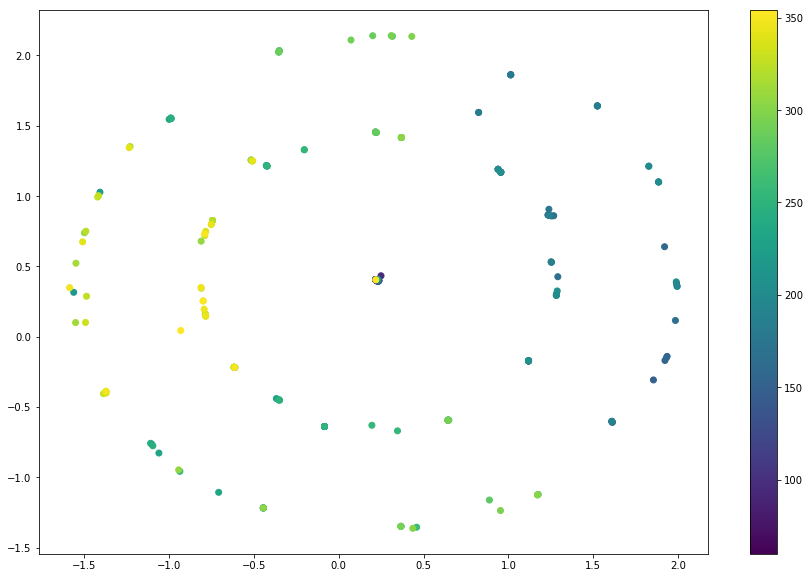

In [63]:
fig, ax = plt.subplots(figsize=(15, 10))
# # index = np.arange(num_samples)
index = np.arange(60, num_samples-5)
# plt.scatter(image_embedded[:, 0], image_embedded[:, 1], c=index)
plt.scatter(image_embedded[60:355, 0], image_embedded[60:355, 1], c=index)
plt.colorbar()
plt.show()

In [ ]:
'''======================================= divider ====================================='''

In [27]:
''' training example '''
env = robosims.controller.ChallengeController(
    # Use unity_path=thor-201705011400-OSXIntel64.app/Contents/MacOS/thor-201705011400-OSXIntel64 for OSX
    # unity_path='projects/thor-201705011400-Linux64',
    unity_path='../thor-201705011400-OSXIntel64.app/Contents/MacOS/thor-201705011400-OSXIntel64',
    x_display="0.0",  # this parameter is ignored on OSX, but you must set this to the appropriate display on Linux
    mode='continuous'
)
env.start()
recog_net = RecogNet()
max_steps = 500
with open("../thor-challenge-targets/targets-train.json") as f:
    t = json.loads(f.read())
    for target in t:
        env.initialize_target(target)
        # path to the target image (e.g. apple, lettuce, keychain, etc.)
        print(target['targetImage'])
        event = env.step(action=dict(action='Look', horizon=0.0))
        #print(event.metadata['lastActionSuccess'])
        frame = event.frame
        image = Image.fromarray(frame)
        print(type(image))
        print(image.shape)
        break

        step_count = 0
        while (not env.target_found()) and step_count < max_steps:
            # Possible actions are: MoveLeft, MoveRight, MoveAhead, MoveBack, LookUp, LookDown, RotateRight, RotateLeft
            # to plugin agent action here
            event = env.step(action=dict(action='MoveLeft', moveMagnitude=0.25))

            # image of the current frame from the agent - numpy array of shape (300,300,3) in RGB order
            image = event.frame
            image_feature = recog_net.feat_extract(image)
            print(image_feature)
            print(image_feature.data.numpy())
            break        
        break

{
  "ENV_TYPE": "living-room",
  "ENV_NAME": "living-room-0",
  "ENV_BUILD_DARWIN": "../thor-201705011400-OSXIntel64.app/Contents/MacOS/thor-201705011400-OSXIntel64",
  "ENV_BUILD_LINUX": "unity/builds/living-room-Linux64",
  "PROCESS_NAME": "Robot AI Platform",
  "PREFIX": "ROBOSIMS_",
  "X_DISPLAY": "0.0",
  "SMOOTH_ANIMATION": false,
  "TASK_TYPE": "navigation",
  "TASK_TARGET": "balcony",
  "TRAIN_WALK_VELOCITY": 20.0,
  "TRAIN_TURN_VELOCITY": 100.0,
  "TRAIN_ACTION_LENGTH": 1,
  "TEST_WALK_VELOCITY": 2.0,
  "TEST_TURN_VELOCITY": 10.0,
  "TEST_ACTION_LENGTH": 1,
  "AGENT_HEIGHT": 1.8,
  "AGENT_RADIUS": 0.2,
  "COMPUTE_DEPTH_MAP": false,
  "HUMAN_CONTROL_MODE": false,
  "TRAIN_PHASE": false,
  "SERVER_SIDE_SCREENSHOT": false,
  "PLAYER_SCREEN_WIDTH": 300,
  "PLAYER_SCREEN_HEIGHT": 300
}
images/FloorPlan1/spoon.png
<class 'PIL.Image.Image'>


AttributeError: 'Image' object has no attribute 'shape'